In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Görselleştirme ayarları (isteğe bağlı)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Veri setini yükleme
df = pd.read_csv("Police_Transparency_-_Arrests_-_All_Data_(main_table___denormalized).csv")


In [16]:
# Eksik değerleri yüzde olarak hesaplama
missing_percentage = df.isnull().sum() / len(df) * 100
missing_df = pd.DataFrame({
    'Total Missing': df.isnull().sum(),
    'Missing Percentage': missing_percentage
}).sort_values(by='Missing Percentage', ascending=False)

# Sadece eksik değeri olan sütunları göster
missing_df = missing_df[missing_df['Total Missing'] > 0]

print("\nEksik Değerlerin Sayısı ve Yüzdesi:")
print(missing_df.to_markdown(numalign="left", stralign="left"))


Eksik Değerlerin Sayısı ve Yüzdesi:
|                            | Total Missing   | Missing Percentage   |
|:---------------------------|:----------------|:---------------------|
| area_name                  | 2689            | 5.66773              |
| zipcode                    | 2479            | 5.22511              |
| ofc_RaceAndEthnicity       | 1296            | 2.73164              |
| ofc_genderTranslation      | 1296            | 2.73164              |
| ofc_age_range              | 868             | 1.82953              |
| arrest_translation         | 569             | 1.19931              |
| arrest_type                | 569             | 1.19931              |
| arrest_officer             | 567             | 1.19509              |
| severity_code              | 492             | 1.03701              |
| ChargeGrouping             | 126             | 0.265576             |
| arrestee_ethnicity         | 35              | 0.0737712            |
| arrestee_age_range       

In [17]:
# Tekrarlayan satır sayısını kontrol etme
total_duplicates = df.duplicated().sum()

print(f"\nToplam Tekrarlayan Satır Sayısı: {total_duplicates}")

# Eğer tekrarlayan satır varsa, temizleme veya inceleme kararı verilir.
# Örneğin: if total_duplicates > 0: df.drop_duplicates(inplace=True)


Toplam Tekrarlayan Satır Sayısı: 0


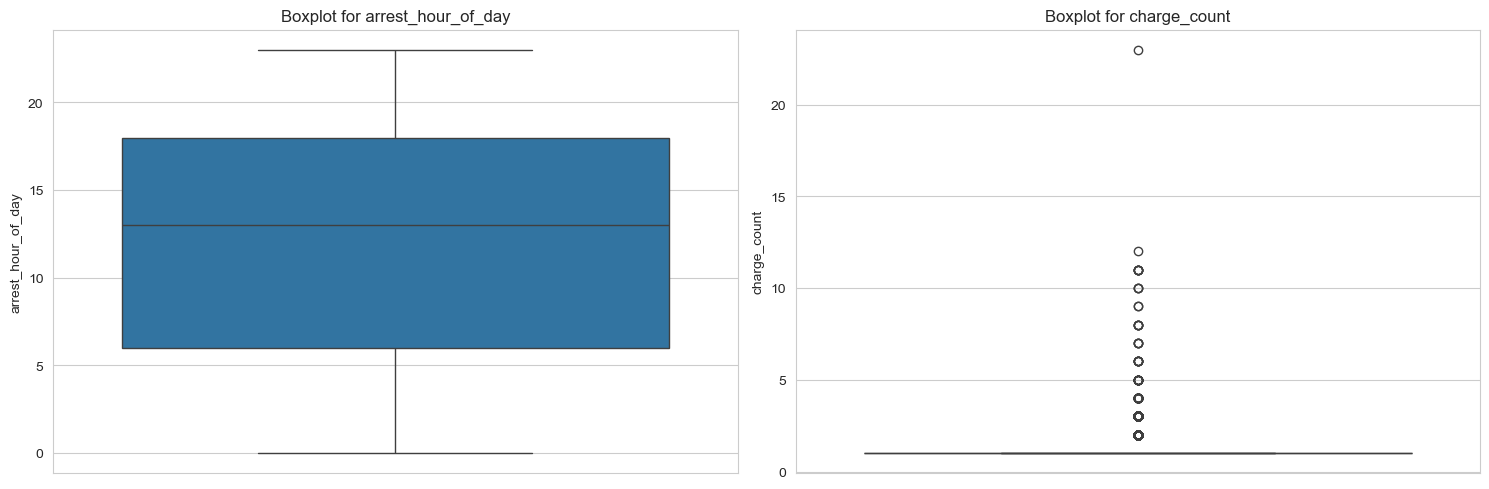

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aykırı değerleri incelemek için sayısal sütunları seçme
numeric_cols = ['arrest_hour_of_day', 'charge_count']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot for {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show() # Jupyter Notebook'ta görseli gösterir

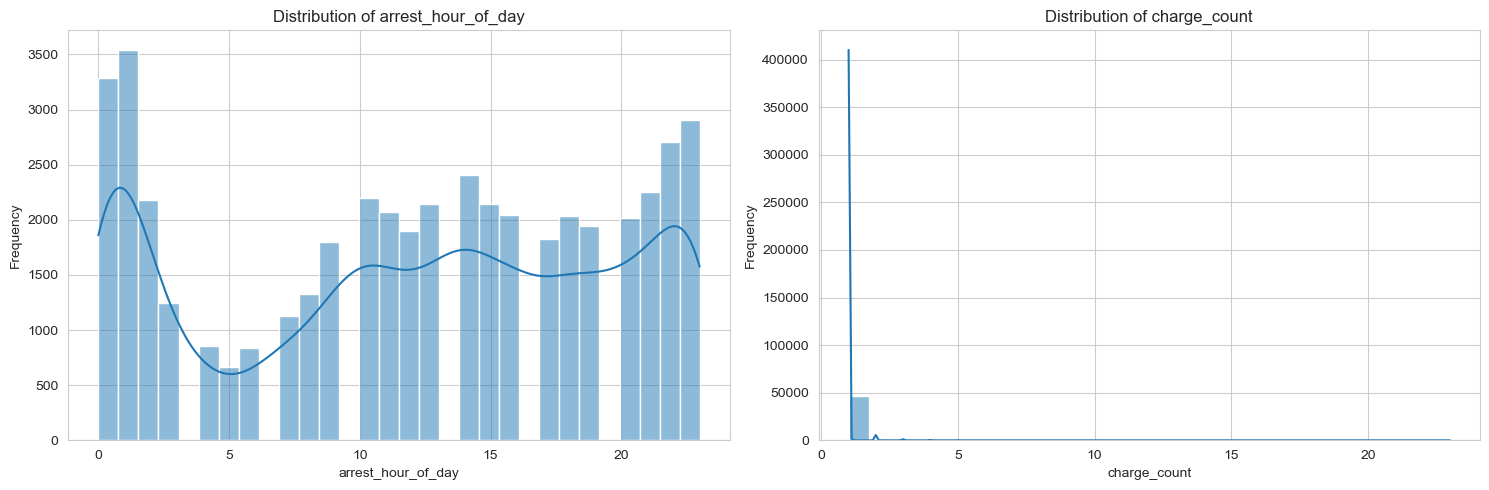

In [19]:
# Sayısal sütunların dağılımları
numeric_cols_for_dist = ['arrest_hour_of_day', 'charge_count']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_cols_for_dist):
    plt.subplot(1, 2, i + 1)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show() # Jupyter Notebook'ta görseli gösterir

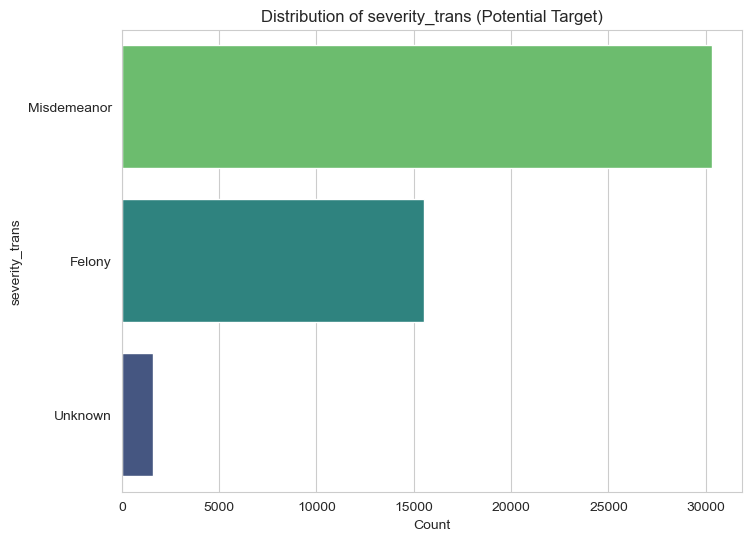

In [20]:
# Potansiyel Hedef Sütununun Dağılımı (Çubuk Grafiği)
target_col = 'severity_trans'

plt.figure(figsize=(8, 6))

# DÜZELTİLMİŞ KOD: y'yi hue'ya atayarak FutureWarning'ı engelleriz
sns.countplot(
    y=df[target_col],
    order=df[target_col].value_counts().index,
    hue=df[target_col],          # Yeni: y değişkenini hue olarak ata
    palette='viridis',
    legend=False                  # Yeni: Legend'ı gizle
)

plt.title(f'Distribution of {target_col} (Potential Target)')
plt.xlabel('Count')
plt.ylabel(target_col)
plt.show()

In [21]:
# Sadece sayısal sütunları seçme
numeric_df = df.select_dtypes(include=['int64', 'float64']).drop(columns=['X', 'Y', 'rin', 'charge_rin', 'ESRI_OID', 'x_coordinate', 'y_coordinate'])

# Korelasyon matrisini hesaplama
correlation_matrix = numeric_df.corr()

# Isı haritası (Heatmap) ile görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Korelasyon Matrisi (Sayısal Sütunlar)')
plt.savefig('correlation_heatmap.png')
plt.close()

In [22]:
from sklearn.feature_selection import mutual_info_classif

# Kategorik ve Nesne (object) veri tiplerini seçme
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Kategori sütunlarını kodlama (mutual_info için)
# Bu adım, kategorik verilerin sayısal temsile çevrilmesini gerektirir.
# Basitlik için sadece yüksek kardinaliteye sahip olmayan sütunları alalım ve hedefi kodlayalım.
df_mi = df[['arrestee_RaceAndEthnicity', 'arrestee_age_range', 'arrest_type', 'municipality', 'severity_trans']].copy()

# Sadece tam (non-null) değerlere sahip satırları alalım
df_mi.dropna(inplace=True)

# Hedef değişkeni sayısal hale getirme
df_mi['severity_trans_encoded'] = df_mi['severity_trans'].astype('category').cat.codes
target_encoded = df_mi['severity_trans_encoded']
features = df_mi.drop(columns=['severity_trans', 'severity_trans_encoded'])

# Kategorik özellikleri tamsayı kodlarına dönüştürme
features_encoded = pd.DataFrame()
for col in features.columns:
    features_encoded[col] = features[col].astype('category').cat.codes

# Karşılıklı bilgi hesaplama
mi_scores = mutual_info_classif(features_encoded, target_encoded, random_state=42)
mi_series = pd.Series(mi_scores, index=features_encoded.columns).sort_values(ascending=False)

print("\nÖzelliklerin Hedef Değişken ile Karşılıklı Bilgi Skorları:")
print(mi_series.to_markdown(numalign="left", stralign="left"))


Özelliklerin Hedef Değişken ile Karşılıklı Bilgi Skorları:
|                           | 0          |
|:--------------------------|:-----------|
| arrest_type               | 0.0176298  |
| municipality              | 0.0174168  |
| arrestee_RaceAndEthnicity | 0.00541873 |
| arrestee_age_range        | 0.00321479 |


In [23]:
# Irk/Etnisiteye göre Suç Ciddiyeti Dağılımı (Cross-tabulation)
crosstab = pd.crosstab(df['arrestee_RaceAndEthnicity'], df['severity_trans'], normalize='index') * 100

print("\nIrk/Etnisiteye Göre Suç Ciddiyeti Yüzde Dağılımı:")
print(crosstab.sort_values(by='Felony', ascending=False).to_markdown(numalign="left", stralign="left"))

# Görselleştirme
crosstab.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Irk/Etnisiteye Göre Suç Ciddiyetinin Yüzde Dağılımı')
plt.ylabel('Yüzde (%)')
plt.xlabel('Tutuklunun Irkı ve Etnisitesi')
plt.legend(title='Suç Ciddiyeti')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('race_severity_crosstab.png')
plt.close()


Irk/Etnisiteye Göre Suç Ciddiyeti Yüzde Dağılımı:
| arrestee_RaceAndEthnicity           | Felony   | Misdemeanor   | Unknown   |
|:------------------------------------|:---------|:--------------|:----------|
| White                               | 35.7259  | 61.0369       | 3.23715   |
| Hispanic or Latino                  | 33.5163  | 63.3876       | 3.09603   |
| Black or African American           | 31.5638  | 64.869        | 3.5672    |
| American Indian or Alaska Native    | 21.7639  | 74.345        | 3.89105   |
| Native Hawaiian or Pacific Islander | 20.6767  | 75.5639       | 3.7594    |
| Asian                               | 19.6995  | 75.2922       | 5.00835   |
| Unknown                             | 17.5676  | 79.0541       | 3.37838   |


In [24]:
# Basitleştirilmiş bir Pair Plot oluşturma
# Sadece seçilen 3 sayısal sütun ve hedef değişken ile
cols_to_plot = ['arrest_hour_of_day', 'charge_count', 'zipcode', 'severity_trans']

# Eksik değerleri temizleyerek veya doldurarak (örneğin 'Unknown' ile) çizim yapılması önerilir.
# Burada sadece çizim için gerekli sütunlardan na değerlerini düşürelim.
df_pair = df[cols_to_plot].dropna()
df_pair['zipcode'] = df_pair['zipcode'].astype(int) # zipcode'u int'e çevirme

sns.pairplot(df_pair, hue='severity_trans', diag_kind='kde')
plt.suptitle('Sayısal Özelliklerin Pair Plotu (Ciddiyete Göre Renklendirilmiş)', y=1.02)
plt.savefig('pairplot_example.png')
plt.close()